## CPU implementation of MPPI for unicycle dynamics without obstacles.

In [1]:
%load_ext autoreload
%matplotlib inline
import os
import copy
import numpy as np
import random
import matplotlib.pyplot as plt
import time 
np.random.seed(0)

Define and test unicycle dynamics

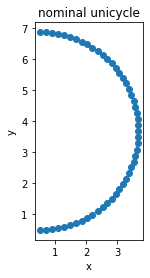

In [2]:

def normalize_angle(th):
  pi_2 = 2*np.pi
  # reduce the angle  
  th =  th % pi_2; 

  # force it to be the positive remainder, so that 0 <= angle < 360  
  th = (th + pi_2) % (pi_2);  

  # force into the minimum absolute value residue class, so that -180 < angle <= 180  
  if th > np.pi:
    th -= pi_2

  return th

class Unicycle:

  def __init__(self):
    pass

  def model(self, x, u, dt):
    assert x.shape == (3, )
    assert u.shape == (2, )
    assert dt >0

    v, w = u
    # print(u[1], w_scale, w)
    x_out = x.copy()
    if w < 1e-4:
      x_out[0] += dt * v * np.cos(x[2])
      x_out[1] += dt * v * np.sin(x[2])
      x_out[2] += w*dt

    else:
      th1 = x[2]
      th2 = th1 + w * dt

      x_out[2] = th2
      x_out[0] += (v/w) * (np.sin(th2)-np.sin(th1))
      x_out[1] -= (v/w) * (np.cos(th2)-np.cos(th1))

    # Clip the output theta (-pi, pi]
    x_out[2] = normalize_angle(x_out[2])
    return x_out

  def rollout(self, x, u_sequence, dt):
    assert x.shape == (3, )
    assert len(u_sequence.shape) == 2
    T = u_sequence.shape[0]
    assert u_sequence.shape[1]==2
    assert T>=1
    assert dt >0

    x_rollout = np.zeros((T+1, 3))
    x_rollout[0,:] = x
    for i in range(T):
        x_rollout[i+1] = self.model(x_rollout[i], u_sequence[i], dt)
    return x_rollout


# Basic test
uni = Unicycle()
x0 = np.array([0.5,0.5,0.0], dtype=float)
dt=0.2
T=10.0
u = np.array([1.0,np.pi/10], dtype=float)
useq = np.tile(u, (int(T/dt), 1))
trajs = uni.rollout(x0, useq, dt)
fig,ax = plt.subplots()
ax.plot(trajs[:,0], trajs[:,1], "-o")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal")
ax.set_title("nominal unicycle")
plt.show()

Define cost functions and MPPI

In [3]:

def min_time_cost(xseq, useq, xgoal, dt, v_post_rollout=0.1, tol=0.1, multiplier=10.0):
  # When x reaches xgoal
  cost = 0
  for x in xseq:
    goal_reached = False
    if np.sqrt((xgoal[0]-x[0])**2 + (xgoal[1]-x[1])**2) < tol:
      goal_reached=True
      break
    else:
      cost += dt
  if not goal_reached:
    t_to_go = np.sqrt((xgoal[0]-xseq[-1,0])**2 + (xgoal[1]-xseq[-1,1])**2)/v_post_rollout
    cost += t_to_go
      
  return multiplier*cost


def min_error_cost(xseq, useq, xgoal, dt, multiplier=10.0):
  cost = 0
  for x in xseq:
    cost += np.linalg.norm(x[:2]-xgoal)**2
  return multiplier*cost


def MPPI(unicycle, dt, x0, xgoal, u_seq0, cost_fn, u_proj_fn, 
        lambda_weight=1.0, N=100, K=3, M=100, u_std=np.array([1.0, 1.0])):
  # K: optimization steps, N: number of rollouts, M: number of samples to approx mean/cvar, T: horizon
  timesteps = u_seq0.shape[0]

  u_seq_history = [u_seq0]
  for k in range(K): # Each optimization step
    # print("optimization round {}".format(k))

    # print(np.zeros((N, timesteps, 2)).shape, np.tile(u_std, (N, timesteps, 1)).shape)
    noise_samples = np.random.normal(np.zeros((N, timesteps, 2)), np.tile(u_std, (N, timesteps, 1)))
    rollout_scores = []

    cost_times = []

    u_cur = u_seq_history[k]
    for n in range(N): # Each rollout
      # print("rollout {}".format(n))
      u = u_cur + noise_samples[n]
      u = u_proj_fn(u)

      t1 = time.time()
      # for m in range(M): # Approximate rollout's cost
      xseq = unicycle.rollout(x0, u, dt)
      cost = cost_fn(xseq, useq, xgoal, dt)

      # Add the missing stage cost
      for t in range(timesteps):
        cost += lambda_weight* (u_cur[t]*(1/u_std**2)@noise_samples[n, t])
      
      rollout_scores.append(cost)

      cost_times.append(time.time()-t1)

    # print("{:.3}s over {} u rollouts".format(np.mean(cost_times), N))

    beta = min(rollout_scores)
    weights = np.array([np.exp(-1/lambda_weight*(score-beta)) for score in rollout_scores])
    weights /= sum(weights)
    # print("Average rollout score: {}".format(np.mean(rollout_scores)))

    # Update rollouts
    u_new = u_cur.copy()
    for w, noise in zip(weights, noise_samples):
      u_new += w*noise
    u_new = u_proj_fn(u_new)
    u_seq_history.append(u_new)

  return u_seq_history[-1], u_seq_history



Replanning

In [4]:

uni = Unicycle()
T = 5 # Planning horizon in seconds
dt = 0.2
mission_time = 3 # 15 # 10 # 3
replan_steps = int(mission_time/dt)
u_seq0 = np.zeros((int(T/dt), 2))
x0=np.array([0.5, 0.5, -np.pi/4])
xgoal= np.array([2, 2])
vrange = np.array([0, 3])
wrange = np.array([-np.pi, np.pi])

def u_proj_fn(useq):
  useq_out = useq.copy()
  useq_out[:, 0] = np.clip(useq[:, 0], vrange[0], vrange[1])
  useq_out[:, 1] = np.clip(useq[:, 1], wrange[0], wrange[1])
  return useq_out

num_rollouts = int(1e3)

default_MPPI_args = dict(
  unicycle=uni, 
  dt=dt, 
  x0=x0, 
  xgoal=xgoal, 
  u_seq0=u_seq0, 
  # cost_fn=min_time_cost,
  cost_fn=min_error_cost, 
  u_proj_fn=u_proj_fn,
  lambda_weight=1.0, 
  N=num_rollouts, # num rollouts
  K=1, # num optimization step
  u_std=np.array([1.0, 1.0]) # control noise
)


xhist = np.zeros((replan_steps+1, 3))
xhist[0,:] = x0
uhist = np.zeros((replan_steps, 2))

In [5]:
# How quickly does it take to solve?
MPPI_args = copy.deepcopy(default_MPPI_args)
%timeit -n 5 -r 5 MPPI(**MPPI_args)

254 ms ± 615 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


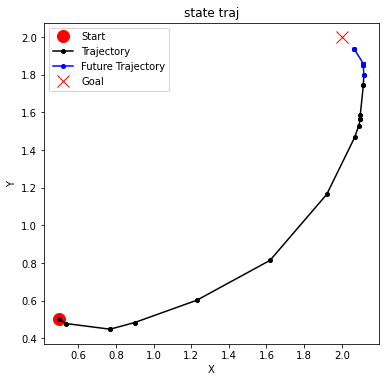

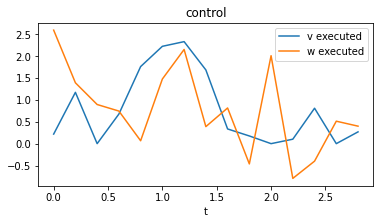

In [6]:


for i in range(replan_steps):
  # Update mppi arguments
  MPPI_args = copy.deepcopy(default_MPPI_args)
  MPPI_args['x0'] = xhist[i]
  
  # Plan and move
  useq_opt, useq_history = MPPI(**MPPI_args)
  xhist[i+1] = uni.model(xhist[i], useq_opt[0], dt)
  uhist[i] = useq_opt[0]

# Simulate future traj at the end of planning horizon
future_traj = uni.rollout(xhist[-1], useq_opt, dt)


fig,ax = plt.subplots(figsize=(6, 6))
ax.plot(xhist[0,0], xhist[0,1], "ro", markersize=12, label="Start")
ax.plot(xhist[:,0], xhist[:,1], "ko-", markersize=4, label="Trajectory")
ax.plot(future_traj[:,0], future_traj[:,1], "bo-", markersize=4, label="Future Trajectory")
ax.plot(xgoal[0], xgoal[1], "rx", markersize=12, label="Goal")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_aspect("equal")
ax.set_title("state traj")
ax.legend()

fig,ax = plt.subplots(figsize=(6, 3))
ax.plot(np.linspace(0, mission_time, int(mission_time/dt), endpoint=False), uhist[:,0], label="v executed")
ax.plot(np.linspace(0, mission_time, int(mission_time/dt), endpoint=False), uhist[:,1], label="w executed")
ax.set_xlabel("t")
ax.set_title("control")
ax.legend()

plt.show()